# Model Evaluation

## Agenda

1. Null accuracy, handling missing values
2. Confusion matrix, sensitivity, specificity, setting a threshold
3. Handling categorical features, interpreting logistic regression coefficients
4. Cross-Validation

## Part 1: Null Accuracy, Handling Missing Values

Recall the Lab from last lesson on Logistic Regression. We will be revisting the ideas introduced using the Titanic dataset again.

For a description of the Titanic dataset see this Kaggle page: https://www.kaggle.com/c/titanic/data

In [1]:
# TASK 1: read the data from titanic.csv into a DataFrame
import pandas as pd
titanic = pd.read_csv('titanic.csv', index_col='PassengerId')

# TASK 2: define Pclass/Parch as the features and Survived as the response
feature_cols = ['Pclass', 'Parch']
X = titanic[feature_cols]
y = titanic.Survived
#X = ___
#y = ___

# TASK 3: split the data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# TASK 4: fit a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

# TASK 5: make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print (metrics.accuracy_score(y_test, y_pred_class))

/Users/evan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.6681614349775785


In [5]:
?LogisticRegression

### Null accuracy

Null accuracy is the accuracy that could be achieved by always predicting the **most frequent class**. It is a baseline against which you may want to measure your classifier.

In [2]:
# compute null accuracy manually
print (y_test.mean())
print (1 - y_test.mean())

0.4260089686098655
0.5739910313901345


In [3]:
# equivalent function in scikit-learn
# http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
from sklearn.dummy import DummyClassifier
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(X_train, y_train)
y_dumb_class = dumb.predict(X_test)
print (metrics.accuracy_score(y_test, y_dumb_class))

0.5739910313901345


### Handling missing values

scikit-learn models expect that all values are **numeric** and **hold meaning**. Thus, missing values are not allowed by scikit-learn.

One possible strategy is to just **drop missing values**:

In [10]:
# check for missing values
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [11]:
# drop rows with any missing values
titanic.dropna().shape

(183, 11)

In [12]:
# drop rows where Age is missing
titanic[titanic.Age.notnull()].shape

(714, 11)

Sometimes a better strategy is to **impute missing values**:

In [13]:
# fill missing values for Age with the mean age
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

In [14]:
# equivalent function in scikit-learn, supports mean/median/most_frequent
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean', axis=1)
titanic['Age'] = imp.fit_transform(titanic.Age.reshape(1,-1)).T

/Users/evan/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [15]:
# include Age as a feature
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]

from sklearn.model_selection import train_test_split



# TASK : split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# TASK : fit a logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# TASK : make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print (metrics.accuracy_score(y_test, y_pred_class))

0.6860986547085202


In [4]:
?train_test_split

## Part 2: Confusion Matrix

In [16]:
# confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[112,  16],
       [ 54,  41]])

For a plotting function that will plot a nice confusion matrix see: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [17]:
# %load confusion_matrix_nice.py
# from confusion_matrix_nice import plot_confusion_matrix
%run confusion_matrix_nice

Confusion matrix, without normalization
[[112  16]
 [ 54  41]]


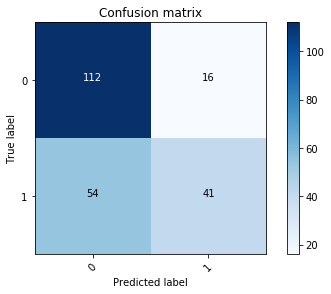

In [18]:
# plot an attractive confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred_class, labels = titanic.Survived.unique())
class_labels = titanic.Survived.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

In [19]:
# calculate the sensitivity
43 / float(52 + 43)

0.45263157894736844

In [20]:
# calculate the specificity
107 / float(107 + 21)

0.8359375

In [21]:
# store the predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

Text(0,0.5,'Frequency')

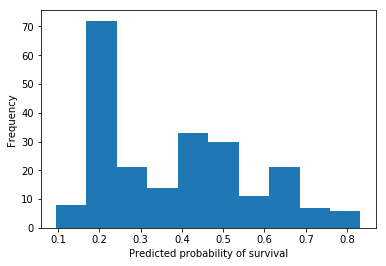

In [22]:
# plot the predicted probabilities
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)
plt.xlabel('Predicted probability of survival')
plt.ylabel('Frequency')

In [23]:
# change the threshold for predicting survived to increase sensitivity
import numpy as np
y_pred_class = np.where(y_pred_prob > 0.25, 1, 0)

In [24]:
# equivalent function in scikit-learn
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob.reshape(1,-1), 0.25).T

In [25]:
# new confusion matrix
print (metrics.confusion_matrix(y_test, y_pred_class))

[[57 71]
 [27 68]]


In [26]:
# new sensitivity
print (68 / float(27 + 68))

0.7157894736842105


In [27]:
# new specificity
print (57 / float(57 + 71))

0.4453125


## Part 3: Cross Validation Example on Bike Share

#### Intro to cross validation with bike share data

In [33]:
from sklearn import cross_validation

bikeshare = pd.read_csv('bikeshare.csv')

#### Create dummy variables and set outcome (dependent) variable

In [67]:
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather')
modeldata = bikeshare[['temp', 'hum']].join(weather[['weather_1', 'weather_2', 'weather_3']])
y = bikeshare.casual 

In [68]:
print(weather)

       weather_1  weather_2  weather_3  weather_4
0              1          0          0          0
1              1          0          0          0
2              1          0          0          0
3              1          0          0          0
4              1          0          0          0
5              0          1          0          0
6              1          0          0          0
7              1          0          0          0
8              1          0          0          0
9              1          0          0          0
10             1          0          0          0
11             1          0          0          0
12             1          0          0          0
13             0          1          0          0
14             0          1          0          0
15             0          1          0          0
16             0          1          0          0
17             0          1          0          0
18             0          0          1          0


In [63]:
?pd.get_dummies

#### Create a cross validation with 5 folds

In [35]:
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)

In [43]:
from sklearn import linear_model

In [44]:
mse_values = []
scores = []
n= 0
print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
    print ('Model', n)
    print ('MSE:', mse_values[n-1])
    print ('R2:', scores[n-1])


print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 1756.4243304904096
R2: 0.3119159468570686
Model 2
MSE: 1698.3398668364784
R2: 0.3119077517967531
Model 3
MSE: 1717.8722477722902
R2: 0.31191657356014224
Model 4
MSE: 1619.0718140926544
R2: 0.31192038682981493
Model 5
MSE: 1573.4077261681887
R2: 0.31191011194417195
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 1673.0231970720045
Mean of R2 for all folds: 0.31191415419759017


In [45]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print ("~~~~ Single Model ~~~~")
print ('MSE of single model:', metrics.mean_squared_error(y, lm.predict(modeldata)))
print ('R2: ', lm.score(modeldata, y))

~~~~ Single Model ~~~~
MSE of single model: 1672.5811076539346
R2:  0.31193460598906453


### Check
While the cross validated approach here generated more overall error, which of the two approaches would predict new data more accurately: the single model or the cross validated, averaged one? Why?


Answer: 

In [ ]:
Cross validated

## Part 4: Apply Cross Validation to the Titanic Dataset

In [46]:
import pandas as pd
titanic = pd.read_csv('titanic.csv', index_col='PassengerId')

In [66]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [50]:
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [51]:
titanic.dropna().shape

(183, 11)

In [61]:
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

In [57]:
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]
y = titanic.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg=LogisticRegression()
logreg.fit(X_train, y_train)
zip(feature_cols, logreg.coef_[0])

In [58]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=100)
print (scores)
print (scores.mean())

[0.8        0.7        0.3        0.7        0.7        0.6
 0.8        0.5        0.6        0.9        0.5        0.5
 0.6        0.6        0.6        0.5        0.7        0.6
 0.7        0.8        0.7        0.8        0.8        0.7
 0.5        0.5        0.9        0.7        0.8        0.6
 0.8        0.5        0.9        0.6        0.4        0.6
 0.9        0.8        0.6        0.7        0.7        0.8
 0.88888889 0.66666667 0.77777778 0.77777778 0.66666667 0.77777778
 0.55555556 0.875      0.75       0.625      0.625      0.75
 0.625      0.75       0.75       0.75       0.75       0.75
 0.625      0.75       0.875      0.625      0.875      1.
 0.875      0.75       0.875      0.75       0.5        0.75
 0.75       0.625      0.875      0.625      0.75       0.875
 0.875      0.875      0.625      0.875      0.625      0.625
 0.875      0.75       0.625      0.5        0.75       0.625
 0.75       0.625      0.75       0.75       1.         0.875
 0.625      0.625      

### Task: Evaluate each stage of the model with Cross-Validation

In [72]:
from sklearn import cross_validation
from sklearn import linear_model

feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]
y = titanic.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg=LogisticRegression()
logreg.fit(X_train, y_train)
zip(feature_cols, logreg.coef_[0])

kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)

mse_values = []
scores = []
n= 0
print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
    print ('Model', n)
    print ('MSE:', mse_values[n-1])
    print ('R2:', scores[n-1])


print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 0.2266498141983207
R2: 0.1536786016365056
Model 2
MSE: 0.19266137840197553
R2: 0.15406384236706394
Model 3
MSE: 0.19802049316991344
R2: 0.15426602117896726
Model 4
MSE: 0.19753759892512263
R2: 0.15388908133725188
Model 5
MSE: 0.19120390612658622
R2: 0.15410071217667254
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.2012146381643837
Mean of R2 for all folds: 0.15399965173929225


### Task: Evaluate the Cross-Validation score with different values of n (2, 5, 10, 50)

In [77]:
# n = 2
kf = cross_validation.KFold(len(modeldata), n_folds=2, shuffle=True)

mse_values = []
scores = []
n= 0
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1

print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.20834622039179582
Mean of R2 for all folds: 0.14262084686082765


In [78]:
# n = 10
kf = cross_validation.KFold(len(modeldata), n_folds=10, shuffle=True)

mse_values = []
scores = []
n= 0
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1

print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.20171813855513468
Mean of R2 for all folds: 0.1542193408058686


In [79]:
# n = 50
kf = cross_validation.KFold(len(modeldata), n_folds=50, shuffle=True)

mse_values = []
scores = []
n= 0
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1

print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 0.2012577330880991
Mean of R2 for all folds: 0.15455766509868013


### Task: Experiment with differen model evaluation metrics form sci-kit learn

See a list of model evaluatin metrics here. Particulary try precision and recall and f1. Read about available methods and what they mean here:
http://scikit-learn.org/stable/modules/model_evaluation.html

